# Demonstration of the TuringOnline package

In this notebook we will provide a use case of the TuringOnline package in order to illustrate its benefits and to provide evidence for the correct working.

The package aims to provide online updates of inferred parameter sets, given parameter samples from e.g. a MCMC algorithm and new, i.e. previously unseen data.

The notebook is structured as follows:

## Table of contents
1. [Used packages](#import)
1. [Model](#model)    
1. [Data generation](#data)
    1. [Independent variables](#data_indep)
    1. [Dependent variables](#data_dep)
    1. [Suitability of generated data](#data_suit)
1. [Benchmark](#bench)
    1. [Speed and memory consumption](#bench_speed)
    1. [Accuracy](#bench_acc)
1. [Repeated updates](#loop)
1. [Summary](#sum)

## Used packages <a name="import"></a>

In [1]:
import PyPlot as plt
import Seaborn as sns
import Pandas as pd

In [2]:
import Random as rnd
import Distributions as dist

In [3]:
import Turing as tur

In [4]:
import AdvancedPS as aps

In [5]:
import DynamicPPL as ppl

In [6]:
rng = rnd.seed!(1)

MersenneTwister(1)

In [7]:
include("../src/TuringOnline.jl")
using Revise
import .online as online

In [235]:
include("./scoring.jl")
import .scoring as scoring

In [8]:
using BenchmarkTools

In [9]:
using Suppressor

## Model <a name="model"></a>
As a model we use a generalized additive linear model for a poisson-distributed random variable, e.g. cases of a disease in an epidemiological study.

In [163]:
# The TV syntax allows sampling to be type-stable.
tur.@model function garch(y)
    T = length(y)

    # Declare priors on parameters.
    omega ~ dist.TruncatedNormal(0,1,0,Inf)
    alpha ~ dist.TruncatedNormal(0,1,0,Inf)
    beta ~ dist.TruncatedNormal(0,1,0,Inf)

    # Initialize conditional variance vector.
    #sigmaSquared =  ones(T)#Vector{Float64}(undef, T)

    # Treat the first h as a parameter to estimate.
    #sigmaSquared[1] ~ dist.Exponential(1)#dist.TruncatedNormal(0,1,0,Inf)
    
    sigmaSquared ~ tur.filldist(dist.Exponential(1),T)
    
    
    # if y is missing, use a sample for y[1]
    if y[1] === missing
        y[1] ~dist.Normal(0, 1)
    end
    
    # Observe each data point.
    for t in 2:T
        sigmaSquared[t] = omega + alpha * y[t-1]^2 + beta * sigmaSquared[t-1]
        y[t] ~ dist.Normal(0, sqrt(sigmaSquared[t]))
    end
    
    return (y=y,omega=omega,alpha=alpha,beta=beta)
end

garch (generic function with 4 methods)

In [184]:
missing_y =  fill(missing,50);

In [185]:
m_missing_full = garch(missing_y)

DynamicPPL.Model{typeof(garch), (:y,), (), (), Tuple{Vector{Missing}}, Tuple{}, DynamicPPL.DefaultContext}(:garch, garch, (y = [missing, missing, missing, missing, missing, missing, missing, missing, missing, missing  …  missing, missing, missing, missing, missing, missing, missing, missing, missing, missing],), NamedTuple(), DynamicPPL.DefaultContext())

In [186]:
prior_chain = tur.sample(m_missing_full, tur.Prior(), 2)

Chains MCMC chain (2×104×1 Array{Float64, 3}):

Iterations        = 1:1:2
Number of chains  = 1
Samples per chain = 2
Wall duration     = 0.0 seconds
Compute duration  = 0.0 seconds
parameters        = omega, alpha, beta, sigmaSquared[1], sigmaSquared[2], sigmaSquared[3], sigmaSquared[4], sigmaSquared[5], sigmaSquared[6], sigmaSquared[7], sigmaSquared[8], sigmaSquared[9], sigmaSquared[10], sigmaSquared[11], sigmaSquared[12], sigmaSquared[13], sigmaSquared[14], sigmaSquared[15], sigmaSquared[16], sigmaSquared[17], sigmaSquared[18], sigmaSquared[19], sigmaSquared[20], sigmaSquared[21], sigmaSquared[22], sigmaSquared[23], sigmaSquared[24], sigmaSquared[25], sigmaSquared[26], sigmaSquared[27], sigmaSquared[28], sigmaSquared[29], sigmaSquared[30], sigmaSquared[31], sigmaSquared[32], sigmaSquared[33], sigmaSquared[34], sigmaSquared[35], sigmaSquared[36], sigmaSquared[37], sigmaSquared[38], sigmaSquared[39], sigmaSquared[40], sigmaSquared[41], sigmaSquared[42], sigmaSquared[43], sigmaSquared[

In [187]:
generated = tur.generated_quantities(m_missing_full, prior_chain);

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311


In [188]:
y = tur.generated_quantities(m_missing_full, prior_chain)[1][:y]

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311


50-element Vector{Union{Missing, Float64}}:
    0.944021060938173
    3.12183929883927
    0.4377714218182983
   -3.727710638403744
   10.853759020024174
   31.98242451394792
  -65.62450323203215
   21.067177276378544
  -31.635415580180737
  -30.714659329100932
 -122.45224430859234
 -325.6807135413568
 -162.29827656297297
    ⋮
   -3.1430478766755234e6
    3.420354992480873e6
    2.471406057813204e6
   -8.678673201396551e6
   -2.2226010409674574e7
    1.0436240575563641e7
    7.414465938914223e7
    3.2467732511675034e7
   -7.34817547780769e7
    1.9082188679649705e8
   -3.674827033795938e7
    4.5083700636743045e8

In [189]:
trueVals = Dict()

Dict{Any, Any}()

In [190]:
parameters = [:omega,:alpha,:beta]

3-element Vector{Symbol}:
 :omega
 :alpha
 :beta

In [191]:
@suppress begin

for key in parameters
    trueVals[key] = tur.generated_quantities(m_missing_full, prior_chain)[1][key]
end
trueVals
end

Dict{Any, Any} with 3 entries:
  :omega => 1.04155
  :alpha => 0.905768
  :beta  => 1.37983

### Show the data

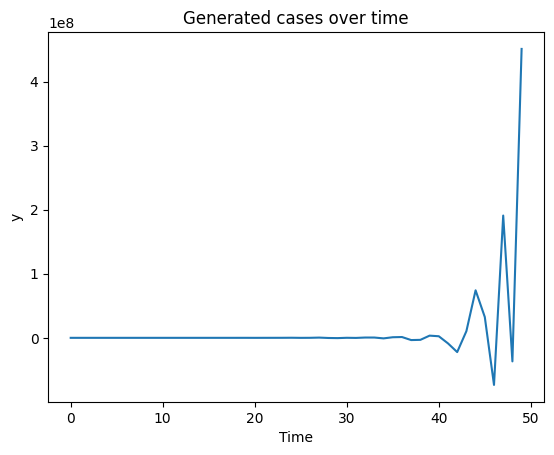

In [192]:
plt.title("Generated cases over time")
plt.plot(y);
plt.ylabel("y");
plt.xlabel("Time");

### Show suitablity by inference through NUTS with full data <a name="data_suit"></a>
We consider the NUTS algorithm as a reference standard and show that the data contains enough information for a meaningful inference.

In [193]:
m_full = garch(y);

In [194]:
NUTS = tur.NUTS();

In [195]:
num_chains = 2
num_samples = 1000;

In [196]:
chain_NUTS_full =  tur.sample(m_full, NUTS, tur.MCMCThreads(), num_samples, num_chains; discard_adapt=true);

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/konstantin/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47


In [197]:
summaryNUTS = tur.summarize(chain_NUTS_full).nt

(parameters = [:omega, :alpha, :beta, Symbol("sigmaSquared[1]"), Symbol("sigmaSquared[2]"), Symbol("sigmaSquared[3]"), Symbol("sigmaSquared[4]"), Symbol("sigmaSquared[5]"), Symbol("sigmaSquared[6]"), Symbol("sigmaSquared[7]")  …  Symbol("sigmaSquared[41]"), Symbol("sigmaSquared[42]"), Symbol("sigmaSquared[43]"), Symbol("sigmaSquared[44]"), Symbol("sigmaSquared[45]"), Symbol("sigmaSquared[46]"), Symbol("sigmaSquared[47]"), Symbol("sigmaSquared[48]"), Symbol("sigmaSquared[49]"), Symbol("sigmaSquared[50]")], mean = [0.9239870517245253, 1.6435433978609344, 1.0552244249940044, 1.2897237395042787, 1.0204008152511739, 1.0005779792094494, 0.9874208389095422, 1.0033213022410488, 1.0091293497901082, 1.0116367668312944  …  1.0004051005285386, 1.0138215266581405, 1.0249148159184969, 0.984106446254209, 0.9890855370188233, 1.004368279301692, 0.9856578985244032, 0.9949962685869498, 0.9976060347332397, 1.0221870793012315], std = [0.6220548507473861, 0.4688175222139785, 0.215821606747782, 1.15732076785

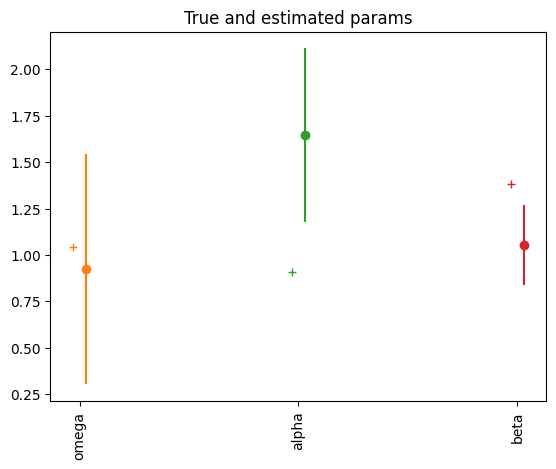

In [198]:
jitter = 0.03
plt.title("True and estimated params")
for (i,p) in enumerate(parameters)
  plt.plot(i-jitter,trueVals[p],"+",label="True",color="C$i");
  plt.errorbar(x=i+jitter,y=summaryNUTS.mean[i],yerr=summaryNUTS.std[i],fmt="o",color="C$i",label="Est")
end

# ticks
plt.xticks(1:length(parameters), parameters, rotation="vertical")

#plt.legend();
#plt.ylabel("theta")
#plt.xlabel("Time");

As the estimated parameters match the true values by eye, we conclude that this data and model can be considered as a suitable testing ground.

In [243]:
scoring.getScore(chain_NUTS_full,[:omega,:alpha,:beta],trueVals)

3.613447056440741

## Benchmark of updating <a name="bench"></a>
We consider the situation where data and inferred parameters up to a point t in time are available and new data arrives at time t+1.

In [199]:
someTime = length(time)-10

40

In [200]:
y_t =  y[1:someTime]

40-element Vector{Union{Missing, Float64}}:
       0.944021060938173
       3.12183929883927
       0.4377714218182983
      -3.727710638403744
      10.853759020024174
      31.98242451394792
     -65.62450323203215
      21.067177276378544
     -31.635415580180737
     -30.714659329100932
    -122.45224430859234
    -325.6807135413568
    -162.29827656297297
       ⋮
 -229688.35628906643
 -435935.91056513437
   62994.26054965707
 -130265.43396688758
  463970.1956078735
  452790.9669408574
 -852366.6773488491
  924430.3468482462
       1.2546537310570944e6
      -3.489886943825381e6
      -3.1430478766755234e6
       3.420354992480873e6

In [201]:
y_t_inc = y[1:someTime+1]

41-element Vector{Union{Missing, Float64}}:
       0.944021060938173
       3.12183929883927
       0.4377714218182983
      -3.727710638403744
      10.853759020024174
      31.98242451394792
     -65.62450323203215
      21.067177276378544
     -31.635415580180737
     -30.714659329100932
    -122.45224430859234
    -325.6807135413568
    -162.29827656297297
       ⋮
 -435935.91056513437
   62994.26054965707
 -130265.43396688758
  463970.1956078735
  452790.9669408574
 -852366.6773488491
  924430.3468482462
       1.2546537310570944e6
      -3.489886943825381e6
      -3.1430478766755234e6
       3.420354992480873e6
       2.471406057813204e6

In [204]:
model_t = garch(y_t)

DynamicPPL.Model{typeof(garch), (:y,), (), (), Tuple{Vector{Union{Missing, Float64}}}, Tuple{}, DynamicPPL.DefaultContext}(:garch, garch, (y = Union{Missing, Float64}[0.944021060938173, 3.12183929883927, 0.4377714218182983, -3.727710638403744, 10.853759020024174, 31.98242451394792, -65.62450323203215, 21.067177276378544, -31.635415580180737, -30.714659329100932  …  62994.26054965707, -130265.43396688758, 463970.1956078735, 452790.9669408574, -852366.6773488491, 924430.3468482462, 1.2546537310570944e6, -3.489886943825381e6, -3.1430478766755234e6, 3.420354992480873e6],), NamedTuple(), DynamicPPL.DefaultContext())

In [205]:
model_t_inc = garch(y_t_inc)

DynamicPPL.Model{typeof(garch), (:y,), (), (), Tuple{Vector{Union{Missing, Float64}}}, Tuple{}, DynamicPPL.DefaultContext}(:garch, garch, (y = Union{Missing, Float64}[0.944021060938173, 3.12183929883927, 0.4377714218182983, -3.727710638403744, 10.853759020024174, 31.98242451394792, -65.62450323203215, 21.067177276378544, -31.635415580180737, -30.714659329100932  …  -130265.43396688758, 463970.1956078735, 452790.9669408574, -852366.6773488491, 924430.3468482462, 1.2546537310570944e6, -3.489886943825381e6, -3.1430478766755234e6, 3.420354992480873e6, 2.471406057813204e6],), NamedTuple(), DynamicPPL.DefaultContext())

#### Get a chain from nuts
We assume here that the parameter set up to time t is also available, we use NUTS as a reference for that:

In [206]:
chain_t = tur.sample(model_t, NUTS, tur.MCMCThreads(), num_samples, num_chains; discard_adapt=true)

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Chains MCMC chain (1000×55×2 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 2
Samples per chain = 1000
Wall duration     = 5.59 seconds
Compute duration  = 5.48 seconds
parameters        = omega, alpha, beta, sigmaSquared[1], sigmaSquared[2], sigmaSquared[3], sigmaSquared[4], sigmaSquared[5], sigmaSquared[6], sigmaSquared[7], sigmaSquared[8], sigmaSquared[9], sigmaSquared[10], sigmaSquared[11], sigmaSquared[12], sigmaSquared[13], sigmaSquared[14], sigmaSquared[15], sigmaSquared[16], sigmaSquared[17], sigmaSquared[18], sigmaSquared[19], sigmaSquared[20], sigmaSquared[21], sigmaSquared[22], sigmaSquared[23], sigmaSquared[24], sigmaSquared[25], sigmaSquared[26], sigmaSquared[27], sigmaSquared[28], sigmaSquared[29], sigmaSquared[30], sigmaSquared[31], sigmaSquared[32], sigmaSquared[33], sigmaSquared[34], sigmaSquared[35], sigmaSquared[36], sigmaSquared[37], sigmaSquared[38], sigmaSquared[39], sigmaSquared[40]
internals         = lp, n_steps, is_accept, acceptance_r

### Speed and memory consumption <a name="bench_speed"></a>

In [207]:
@benchmark online.update(chain_t,model_t_inc,tur.SMC(),rng) seconds = 60

Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[41]")]) 
Using prior samples from the model for them instead.
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[41]")]) 
Using prior samples from the model for them instead.
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[41]")]) 
Using prior samples from the model for them instead.
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[41]")]) 
Using prior samples from the model for them instead.
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[41]")]) 
Using prior samples from the model for them instead.
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[41]")]) 
Using prior samples from the model for them instead.
Some parameters in are not present in the chain but in the

BenchmarkTools.Trial: 17 samples with 1 evaluation.
 Range (min … max):  3.307 s …    4.278 s  ┊ GC (min … max): 12.27% … 21.60%
 Time  (median):     3.479 s               ┊ GC (median):    13.51%
 Time  (mean ± σ):   3.571 s ± 263.776 ms  ┊ GC (mean ± σ):  14.92% ±  3.30%

  █ ▁█   ▁▁▁█   ▁    ▁   ▁ ▁  ▁            ▁               ▁  
  █▁██▁▁▁████▁▁▁█▁▁▁▁█▁▁▁█▁█▁▁█▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  3.31 s         Histogram: frequency by time         4.28 s <

 Memory estimate: 3.87 GiB, allocs estimate: 8226978.

In [208]:
@benchmark tur.sample(model_t_inc, NUTS, tur.MCMCThreads(), num_samples, num_chains; discard_adapt=true) seconds = 60

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/konstantin/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/konstantin/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/konstantin/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQ

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/konstantin/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step 

BenchmarkTools.Trial: 13 samples with 1 evaluation.
 Range (min … max):  4.608 s …   4.961 s  ┊ GC (min … max): 12.00% … 12.76%
 Time  (median):     4.805 s              ┊ GC (median):    12.46%
 Time  (mean ± σ):   4.794 s ± 97.350 ms  ┊ GC (mean ± σ):  12.46% ±  0.34%

  ▁         ▁     ▁      ▁ ▁▁    ▁ ▁ █     ▁          ▁   ▁  
  █▁▁▁▁▁▁▁▁▁█▁▁▁▁▁█▁▁▁▁▁▁█▁██▁▁▁▁█▁█▁█▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁█▁▁▁█ ▁
  4.61 s         Histogram: frequency by time        4.96 s <

 Memory estimate: 5.48 GiB, allocs estimate: 7100676.

The two results above indicate that the online updates is faster and requires less memory.

### Accuracy <a name="bench_acc"></a>
We compare the estimated values from the online update and from NUTS to the true values.

In [209]:
newChain = online.update(chain_t,model_t_inc,tur.SMC(),rng);

Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[41]")]) 
Using prior samples from the model for them instead.


In [210]:
chain_t_inc = tur.sample(model_t_inc, NUTS, tur.MCMCThreads(), num_samples, num_chains; discard_adapt=true);

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/konstantin/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47


In [211]:
dictChains = Dict("Update" => newChain, "NUTS" => chain_t_inc , "True" => prior_chain);

In [212]:
dictColor = Dict("Update" => "C1", "NUTS" => "C2" , "True" => "k");

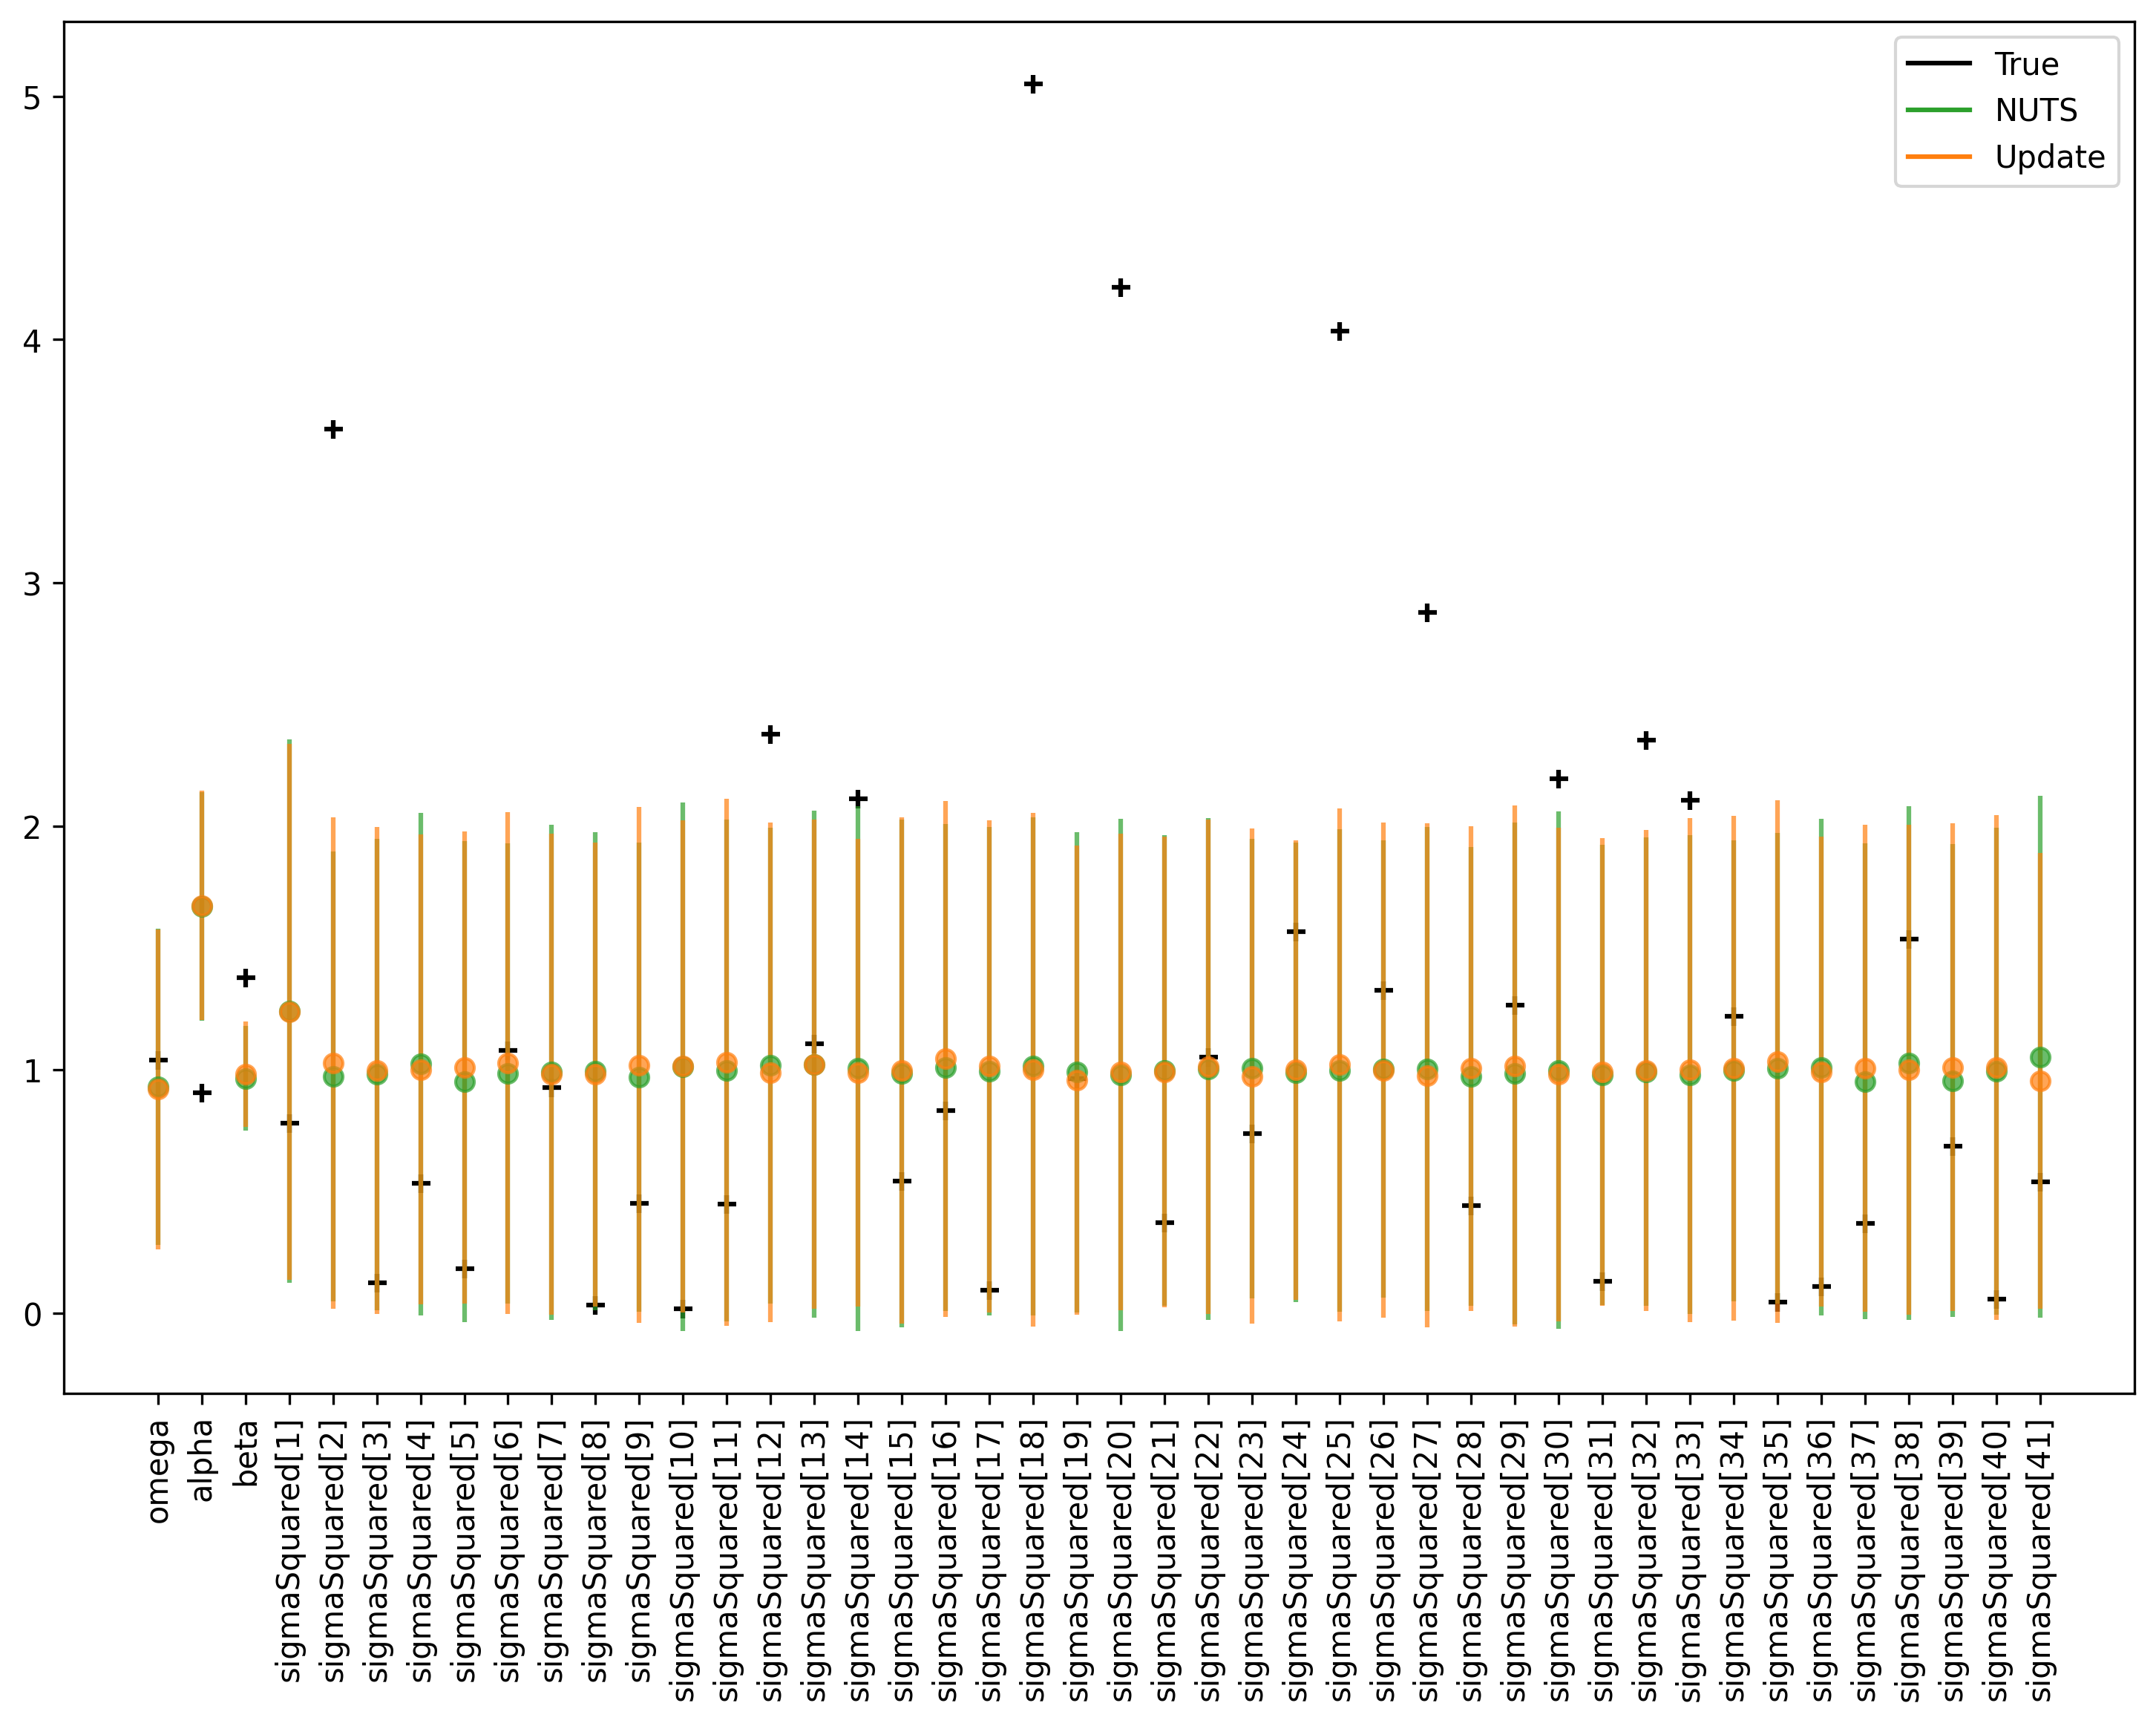

In [213]:
plt.figure(figsize=(12,8),dpi=300)
for (i,sym) in enumerate(chain_t_inc.name_map.parameters)
    for (k,v) in dictChains
        if sym in v.name_map.parameters
            if k != "True"
                # compute statistics
                samples = collect(Iterators.flatten(v[sym].data))
                mean = dist.mean(samples)
                std = dist.std(samples)
                
                # plot errorbars
                plt.errorbar(x=i,y=mean,yerr=std,fmt="o",color=dictColor[k],alpha=0.7)
            else 
                # plot true
                plt.scatter([i],v[sym].data[1,:],color="k",marker="+")
            end
        end        
    
    end
end
# add labels
for (ckey,cvalue) in dictColor
    plt.plot([],[],label=ckey,color=cvalue)
end
plt.legend()

# ticks
plt.xticks(1:length(chain_t_inc.name_map.parameters), chain_t_inc.name_map.parameters, rotation="vertical")

plt.show()

The performance of both algorithms is similar as all estimates are within a fraction of the corresponding standard deviations.

In [241]:
scoring.getScore(chain_t_inc,[:omega,:alpha,:beta],trueVals)

2.3786141431429675

In [242]:
scoring.getScore(newChain,[:omega,:alpha,:beta],trueVals)

2.4227369438218527

## Repeated updates <a name="loop"></a>
We investigate the repeated use of the online update over a time series.

In [222]:
chainDict = Dict()

Dict{Any, Any}()

In [223]:
smc = tur.SMC()

Turing.Inference.SMC{(), AdvancedPS.ResampleWithESSThreshold{typeof(AdvancedPS.resample_systematic), Float64}}(AdvancedPS.ResampleWithESSThreshold{typeof(AdvancedPS.resample_systematic), Float64}(AdvancedPS.resample_systematic, 0.5))

In [226]:
for (i,t) in enumerate(time)
   
    # set up model
    model_t = garch(y[1:i])
    
    if i == 1
        println("NUTS at $i")
        chainDict[(i,"NUTS")] = tur.sample(model_t, NUTS, tur.MCMCThreads(), 100, num_chains; discard_adapt=true)
        println("SMC at $i")
        chainDict[(i,"SMC")] = tur.sample(model_t, smc, tur.MCMCThreads(), 100, num_chains; discard_adapt=true)
    elseif i ==2
        println("NUTS at $i")
        chainDict[(i,"NUTS")] = tur.sample(model_t, NUTS, tur.MCMCThreads(), 100, num_chains; discard_adapt=true)
        println("Online at $i")
        chainDict[(i,"Online")] = online.update(chainDict[(i-1,"NUTS")],model_t,tur.SMC(),rng)
        println("SMC at $i")
        chainDict[(i,"SMC")] = tur.sample(model_t, smc, tur.MCMCThreads(), 100, num_chains; discard_adapt=true)
    else
        println("NUTS at $i.")
        chainDict[(i,"NUTS")] = tur.sample(model_t, NUTS, tur.MCMCThreads(), 100, num_chains; discard_adapt=true)
        println("Online at $i")
        chainDict[(i,"Online")] = online.update(chainDict[(i-1,"Online")],model_t,tur.SMC(),rng)
        println("SMC at $i")
        chainDict[(i,"SMC")] = tur.sample(model_t, smc, tur.MCMCThreads(), 100, num_chains; discard_adapt=true)
    end
end

NUTS at 1
SMC at 1
NUTS at 2


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


Online at 2
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[2]")]) 
Using prior samples from the model for them instead.


┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.20625000000000002
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


SMC at 2
NUTS at 3.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


Online at 3


┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[3]")]) 
Using prior samples from the model for them instead.
SMC at 3
NUTS at 4.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 4
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[4]")]) 
Using prior samples from the model for them instead.
SMC at 4
NUTS at 5.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 5
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[5]")]) 
Using prior samples from the model for them instead.
SMC at 5
NUTS at 6.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 6
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[6]")]) 
Using prior samples from the model for them instead.
SMC at 6


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 7.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 7
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[7]")]) 
Using prior samples from the model for them instead.
SMC at 7
NUTS at 8.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 8
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[8]")]) 
Using prior samples from the model for them instead.
SMC at 8


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 9.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 9
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[9]")]) 
Using prior samples from the model for them instead.
SMC at 9


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 10.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 10
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[10]")]) 
Using prior samples from the model for them instead.
SMC at 10


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 11.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 11
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[11]")]) 
Using prior samples from the model for them instead.
SMC at 11


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 12.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 12
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[12]")]) 
Using prior samples from the model for them instead.
SMC at 12


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 13.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 13
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[13]")]) 
Using prior samples from the model for them instead.
SMC at 13


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 14.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 14
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[14]")]) 
Using prior samples from the model for them instead.
SMC at 14


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 15.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 15
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[15]")]) 
Using prior samples from the model for them instead.
SMC at 15


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 16.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 16
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[16]")]) 
Using prior samples from the model for them instead.
SMC at 16


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 17.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 17
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[17]")]) 
Using prior samples from the model for them instead.
SMC at 17


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 18.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 18
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[18]")]) 
Using prior samples from the model for them instead.
SMC at 18


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 19.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/konstantin/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 19
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[19]")]) 
Using prior samples from the model for them instead.
SMC at 19


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 20.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 20
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[20]")]) 
Using prior samples from the model for them instead.
SMC at 20


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 21.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 21
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[21]")]) 
Using prior samples from the model for them instead.
SMC at 21


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 22.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/konstantin/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/konstantin/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47


Online at 22
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[22]")]) 
Using prior samples from the model for them instead.
SMC at 22


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 23.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/konstantin/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47


Online at 23
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[23]")]) 
Using prior samples from the model for them instead.
SMC at 23


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 24.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 24
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[24]")]) 
Using prior samples from the model for them instead.
SMC at 24


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 25.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 25
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[25]")]) 
Using prior samples from the model for them instead.
SMC at 25


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 26.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 26
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[26]")]) 
Using prior samples from the model for them instead.
SMC at 26


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 27.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/konstantin/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 27
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[27]")]) 
Using prior samples from the model for them instead.
SMC at 27


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 28.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 28
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[28]")]) 
Using prior samples from the model for them instead.
SMC at 28


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 29.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.203125
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 29
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[29]")]) 
Using prior samples from the model for them instead.
SMC at 29


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 30.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/konstantin/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47


Online at 30
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[30]")]) 
Using prior samples from the model for them instead.
SMC at 30


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 31.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/konstantin/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/konstantin/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47


Online at 31
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[31]")]) 
Using prior samples from the model for them instead.
SMC at 31


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 32.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 32
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[32]")]) 
Using prior samples from the model for them instead.
SMC at 32


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 33.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/konstantin/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47


Online at 33
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[33]")]) 
Using prior samples from the model for them instead.
SMC at 33


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 34.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.225
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 34
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[34]")]) 
Using prior samples from the model for them instead.
SMC at 34


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 35.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 35
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[35]")]) 
Using prior samples from the model for them instead.
SMC at 35


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 36.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 36
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[36]")]) 
Using prior samples from the model for them instead.
SMC at 36


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 37.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 37
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[37]")]) 
Using prior samples from the model for them instead.
SMC at 37


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 38.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 38
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[38]")]) 
Using prior samples from the model for them instead.
SMC at 38


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 39.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/konstantin/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47


Online at 39
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[39]")]) 
Using prior samples from the model for them instead.
SMC at 39


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 40.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/konstantin/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47


Online at 40
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[40]")]) 
Using prior samples from the model for them instead.
SMC at 40


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 41.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/konstantin/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 41
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[41]")]) 
Using prior samples from the model for them instead.
SMC at 41


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 42.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 42
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[42]")]) 
Using prior samples from the model for them instead.
SMC at 42


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 43.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 43
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[43]")]) 
Using prior samples from the model for them instead.
SMC at 43


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 44.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.225
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 44
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[44]")]) 
Using prior samples from the model for them instead.
SMC at 44


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 45.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 45
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[45]")]) 
Using prior samples from the model for them instead.
SMC at 45


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 46.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 46
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[46]")]) 
Using prior samples from the model for them instead.
SMC at 46


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 47.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/konstantin/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47


Online at 47
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[47]")]) 
Using prior samples from the model for them instead.
SMC at 47


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 48.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/konstantin/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/konstantin/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47


Online at 48
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[48]")]) 
Using prior samples from the model for them instead.
SMC at 48


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 49.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 49
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[49]")]) 
Using prior samples from the model for them instead.
SMC at 49


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 50.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/konstantin/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47


Online at 50
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[50]")]) 
Using prior samples from the model for them instead.
SMC at 50


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


### Analysis

In [227]:
chainDict

Dict{Any, Any} with 149 entries:
  (15, "SMC")    => MCMC chain (100×20×2 Array{Float64, 3})
  (41, "NUTS")   => MCMC chain (100×56×2 Array{Float64, 3})
  (11, "NUTS")   => MCMC chain (100×26×2 Array{Float64, 3})
  (36, "NUTS")   => MCMC chain (100×51×2 Array{Float64, 3})
  (43, "NUTS")   => MCMC chain (100×58×2 Array{Float64, 3})
  (47, "Online") => MCMC chain (100×52×2 Array{Float64, 3})
  (48, "SMC")    => MCMC chain (100×53×2 Array{Float64, 3})
  (14, "Online") => MCMC chain (100×19×2 Array{Float64, 3})
  (3, "Online")  => MCMC chain (100×8×2 Array{Float64, 3})
  (5, "SMC")     => MCMC chain (100×10×2 Array{Float64, 3})
  (39, "NUTS")   => MCMC chain (100×54×2 Array{Float64, 3})
  (35, "SMC")    => MCMC chain (100×40×2 Array{Float64, 3})
  (7, "NUTS")    => MCMC chain (100×22×2 Array{Float64, 3})
  (25, "NUTS")   => MCMC chain (100×40×2 Array{Float64, 3})
  (33, "Online") => MCMC chain (100×38×2 Array{Float64, 3})
  (30, "SMC")    => MCMC chain (100×35×2 Array{Float64, 3})
  (40, "

In [236]:
function plotEstimates(chainDict,name,prior_chain)
    # time indices
    times = sort(unique([t for (t,m) in keys(chainDict)]))
    
    colorDict = Dict("NUTS" => "C0","Online" => "C1","SMC" => "C2")
    jitter = 0.09
    jitterDict = Dict("NUTS" => -jitter,"Online" => 0.0,"SMC" => jitter)
    
    methods = ["NUTS","Online","SMC"]
    
    # extract values
    for method in methods
        for t in times
            key = (t,method)           
            if haskey(chainDict, key) && Symbol(name) in chainDict[key].name_map.parameters
                samples = collect(Iterators.flatten(chainDict[key][Symbol(name)].data))                
                mean = dist.mean(samples)
                std = dist.std(samples)
                
                # pseudo x with jitter
                x = t
                x += jitterDict[method]

                # plot errorbars
                plt.errorbar(x=x,y=mean,yerr=std,fmt="o",color=colorDict[method])
            end
        end    
    end

    # Add legend
    for method in methods
       plt.plot([],[],color=colorDict[method],label=method) 
    end    
    
    # Show true value
    trueVal = prior_chain[Symbol(name)].data[1,1]
    plt.plot(times,trueVal.*ones(length(times)),color="k",label="True")
    plt.legend()
    
    # set labels
    plt.ylabel(name)
    plt.xlabel("Timestep")
    
    return nothing
end    

plotEstimates (generic function with 1 method)

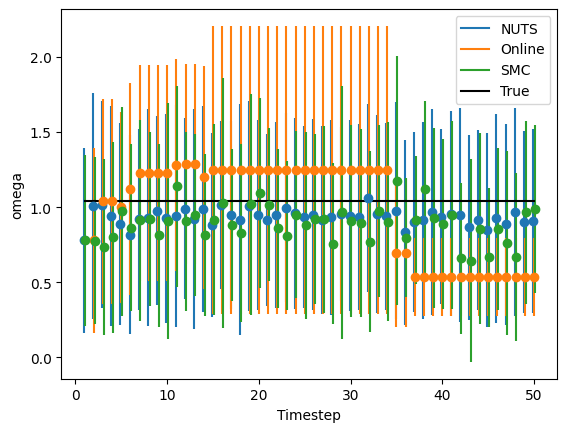

In [229]:
plotEstimates(chainDict,"omega",prior_chain)

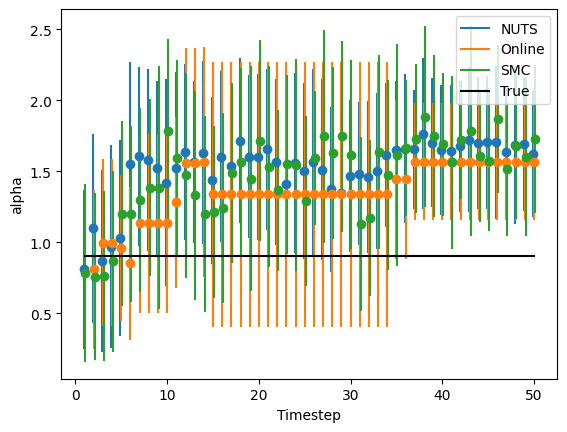

In [230]:
plotEstimates(chainDict,"alpha",prior_chain)

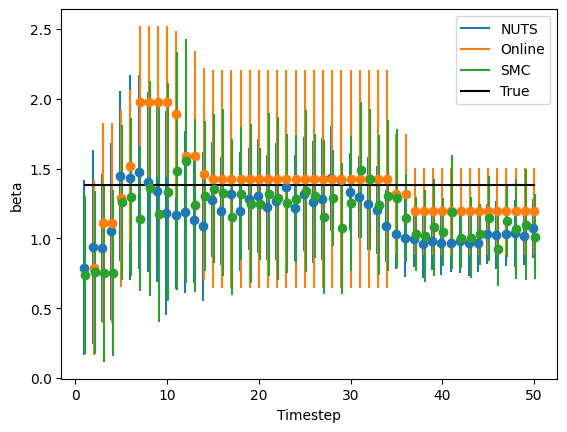

In [231]:
plotEstimates(chainDict,"beta",prior_chain)

In [239]:
function plotScores(chainDict,params,trueVals)
    # time indices
    times = sort(unique([t for (t,m) in keys(chainDict)]))
    
    colorDict = Dict("NUTS" => "C0","Online" => "C1","SMC" => "C2")
    jitter = 0.09
    jitterDict = Dict("NUTS" => -jitter,"Online" => 0.0,"SMC" => jitter)
    
    methods = ["NUTS","Online","SMC"]
    
    # extract values
    for method in methods
        for t in times
            key = (t,method)           
            if haskey(chainDict, key) 
                chain = chainDict[key]
                score = scoring.getScore(chain,params,trueVals)
                
                # pseudo x with jitter
                x = t
                x += jitterDict[method]

                # plot errorbars
                plt.errorbar(x=x,y=score,fmt="o",color=colorDict[method])
            end
        end    
    end

    # Add legend
    for method in methods
       plt.plot([],[],color=colorDict[method],label=method) 
    end  
    plt.legend()
    
    # set labels
    plt.ylabel("Score")
    plt.xlabel("Timestep")
    
    return nothing
end

plotScores (generic function with 1 method)

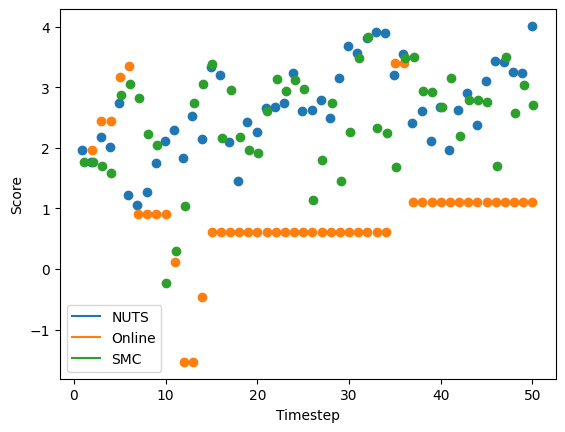

In [240]:
plotScores(chainDict,[:omega,:alpha,:beta],trueVals)

In general, the estimates of the online update agree with the ones of NUTS and the true value within one standard deviation. However, over repteated iterations there is a tendency to converge to narrow range of values. This degenaration could be rooted in the nature of the particle based methods.

## Summary <a name="sum"></a>
We could show that the online updates provided by the TuringOnline package offer a way to get estimates of similar quality, but in less time and with less memory consumption than rerunning the estimation with a reference algorithm like NUTS.

For repteated usage there is the danger of the updated to converge to a narrow range after several updates, such that there may be a certain limit of steps after which one should refresh the estimates by a complete run of e.g. NUTS.

## Use real data <a name="data"></a>
We generate data synthetically by drawing from the model to rule out modelling errors as a cause for bad inference performance.

In [54]:
df = pd.read_csv("returns.txt")

,Year,Mkt-RF,SMB,HML,RF
0,1927,29.47,-2.83,-3.40,3.12
1,1928,35.39,4.51,-6.17,3.56
2,1929,-19.54,-30.69,11.65,4.75
3,1930,-31.23,-5.34,-11.76,2.41
4,1931,-45.11,3.64,-14.56,1.07
5,1932,-9.39,4.56,10.83,0.96
6,1933,57.05,45.46,32.39,0.30
7,1934,3.02,25.60,-27.96,0.16
8,1935,44.96,10.91,8.74,0.17
9,1936,32.07,17.97,34.83,0.18


### Show the data

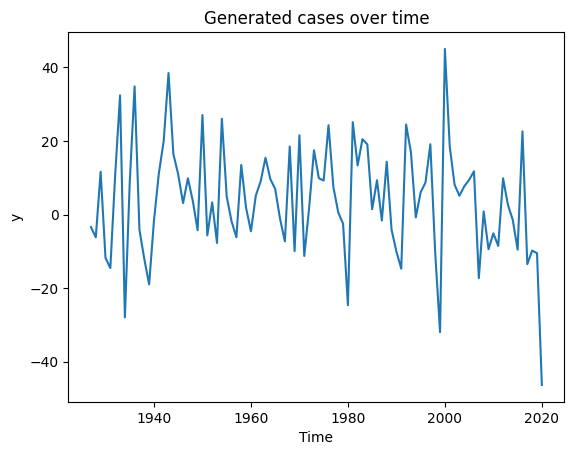

In [87]:
plt.title("Generated cases over time")
plt.plot(df.Year,df.HML);
plt.ylabel("y");
plt.xlabel("Time");